In [13]:
library(sensitivity)
library(ecotoxicology)
source("augmented_utils.R")

parallel = TRUE
registerDoParallel(cores = 5)

### CtoR function to associate the best representatives to a given clustering

In [2]:
vec = seq(10^-10,1-10^-10,l=5000) #just a vector to estimate integral

try_unif_1d = function(samp, delta = NULL){ #this compute the optimal parameters of the 1D uniform
  quantiles_vec = quantile(samp, vec) #computation of the empirical quantile function on [0,1]
  if(is.null(delta)){ #if the width of the support is free
    u_bound = mean(quantiles_vec*(6*vec-2)) #estimate upper bound
    l_bound = mean(quantiles_vec*(-6*vec+4)) #estimate lower bound
  }
  else{ #if width of support is given
    l_bound = mean(quantiles_vec-delta/2) #estimate lower bound
    u_bound = l_bound+delta #estimate upper bound
  }
  return(matrix(c(l_bound, u_bound)))
  
}

CtoR = function(clusts, only_bornes = TRUE, n_sample = 500, return_error = FALSE){ #function that associate the best representative, either a dirac or a uniform on each marginal
  rep = list()
  law = list()
  local_errors = c() 
  for(j in 1:length(clusts)){ #for each cluster, the optimal representative will be provided
    mat = NULL
    law_j = c()
    diss_tot = 0 #quantization error
    for(k in 1:ncol(clusts[[j]])){ #for each marginal
      diss_unif = 10^5
      for(delta in c(1/4,1/2,3/4,1)){ #try the support width 0.25,0.5,0.75 and 1
       unif_prov = try_unif_1d(clusts[[j]][,k], delta = delta) #get the uniform with given width
       unif_tilde_prov = from_law_to_sample(list(unif_prov), law = list("unif"), n = n_sample)[[1]] #get sample associated with this uniform
       diss_unif_prov = wasserstein1d(unif_tilde_prov, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the uniform
       if(diss_unif_prov < diss_unif){ #if this uniform is the best, save it
         unif = unif_prov
         unif_tilde = unif_tilde_prov
         diss_unif = diss_unif_prov
       }
      }
     dirac = mean(clusts[[j]][,k]) #try dirac representative
     dirac = matrix(c(dirac, dirac)) 
     dirac_tilde = from_law_to_sample(list(dirac), law = list("dirac"), n = n_sample)[[1]]
     diss_dirac = wasserstein1d(dirac_tilde, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the dirac
     if(diss_dirac > diss_unif){ #if the dirac is not the best representative, keep uniform
      if(!only_bornes){mat = cbind(mat, unif_tilde)} #only_bornes=TRUE indicates that the only the parameters of the representatives are returned. If false, then a sample is returned for the representative
       else{mat = cbind(mat, unif)}
       law_j = c(law_j, "unif")
       diss_tot = diss_tot + diss_unif^2
     }
     else{ #if dirac is the best representative, save it
       if(!only_bornes){mat = cbind(mat, dirac_tilde)}
       else{mat = cbind(mat, dirac)}
       law_j = c(law_j, "dirac")
       diss_tot = diss_tot + diss_dirac^2
     }
    }
    rep[[j]] = mat
    law[[j]] = law_j
    local_errors = c(local_errors, sqrt(diss_tot))
  }
  res = list(rep, law)
  if(return_error){res = c(res,  list(local_errors, sapply(clusts, nrow)))}
  return(res)
}


### Function to create random samples that will be investigates (mixtures of uniform and dirac)

In [3]:
create_hybrid_sample = function(n, d){ #create an hybrid sample of 3 representatives
    weights_1 = round(runif(1, min = 0.15, max = 0.7),2) #first weight
    weights_2 = round(runif(1, min = 0.15, max = 1-weights_1-0.15),2) #second weight
    weights_3 = (1-weights_1-weights_2) #third weight
    weights = c(weights_1,weights_2, weights_3)
    sizes = weights*n #size of each cluster
    all_law = list()
    all_rep = list()
    all_clust = list()
    for(xx in 1:3){ #for each cluster
        samp = sobol((10^4*xx+1):(10^4*xx+sizes[xx]), dim = d) #multi dimensional sobol sequence 
        is_unif = which(sample(c(0,1), size = d, replace = TRUE) == 1) #boolean alpha_k to decide if the marginal is uniform or dirac
        size_unif = sample(x= c(0.25,0.5, 0.75,1), size = length(is_unif)) #support width of the uniform
        size_marginal = rep(0, length = d) 
        size_marginal[is_unif] = size_unif #size marginal is either 0 if dirac, or support width if uniform
        repres = runif(n = d, min = 0, max = 1-size_marginal) #lower bound of the uniform (or location of dirac)
        repres = rbind(repres, repres + size_marginal) #upper bound
        law = rep("dirac", d)
        law[is_unif] = "unif"
        all_rep[[xx]] = repres #parameters of the uniform or dirac
        all_clust[[xx]] =  from_unif_to_sample(samp, repres, law) #convert the sobol sequence to a cluster representing the distribution of the representative
        all_law[[xx]] = law #the law : dirac or uniform
    }
    return(list(clusts = all_clust, rep = all_rep, law = all_law))
}


### Function to initialize the algorithm 

In [ ]:
initialize_algo = function(l,d, multistart = 1){ #function to propose initial mixture (randomly selected)
    starts = list()
    for(start in 1:multistart){ #multistart
        weights = rep(1/l, l = l) #equal weights
        all_law = list()
        all_rep = list()
        for(xx in 1:l){
            size_unif = sample(x= c(0,0.25,0.5, 0.75,1), size = d) #select size of uniform (0 is dirac)
            repres = runif(n = d, min = 0, max = 1-size_unif) #lower bound of the uniform
            repres = rbind(repres, repres + size_unif) #upper bound
            law = rep("dirac", d) 
            law[which(size_unif >0.001)] = "unif"
            all_rep[[xx]] = repres 
            all_law[[xx]] = law
        }
    starts[[start]] = list(rep = all_rep, law = all_law) 
    }
    return(starts)
}

### AQ method on each test sample

In [ ]:
path = "df_follow.csv"
set.seed(1234)


list_samples = lapply(1:15, function(ii){create_hybrid_sample(n = 200, d = 3)}) #generate samples of 200 points

true_mixt = list()
aq_mixt = list()
errors_true = list()
errors_aq = list()
evol_errors = list()

write.csv(rbind(c(0,0,0,0)), path, row.names = FALSE)
for(ii in 1:15){ #for each test sample
    errors_aq[[ii]] = c(10^5,10^5) 
    df_follow = as.matrix(read.csv(path))
    write.csv(rbind(df_follow,c(as.numeric(errors_aq[[ii]]), c(0,0))), path, row.names = FALSE) #this is just to follow the evolution of the results
    
    samp = list_samples[[ii]] # get the sample
    errors_true[[ii]] = compute_errors(samp[[1]],samp[[2]], samp[[3]]) #compute true errors and store it
    true_mixt[[ii]] = samp #store the sample
    init = initialize_algo(l = 3, d = 3, multistart = 2) #initialize AQ algo
    for(start in 1:2){ # for each start
        res_hybrid = augmented_quanti(samp = do.call(rbind,samp[[1]]), rep = init[[start]]$rep,vec_prop = c(0.4,0.2,0.1), it_lim = 10,n_sample = 1000,threshold = 0.006, law =init[[start]]$law, prop_search = 1) #AQ algorithm
        best_hybrid = find_best(res_hybrid) #get best mixture
        
        evol_error = get_evol_error(res_hybrid) #get the evolution of the quantization error through the iteration (optional)
        error = compute_errors(best_hybrid[[1]], best_hybrid[[2]], best_hybrid[[3]]) #compute AQ errors with the best mixture
        if(error[[1]] < errors_aq[[ii]][[1]]){ # if AQ error of this start is the lowest, save it
            evol_errors[[ii]] = evol_error
            aq_mixt[[ii]] = list(best_hybrid[[1]], best_hybrid[[2]], best_hybrid[[3]])
            errors_aq[[ii]] = error
    
            df_follow = as.matrix(read.csv(path))
            df_follow[ii+1,] = c(as.numeric(errors_aq[[ii]]), as.numeric(errors_true[[ii]])) #just to track 
            write.csv(df_follow, path, row.names = FALSE)
        }

    }
}

list_results = list(true_mixt = true_mixt, aq_mixt = aq_mixt, errors_true = errors_true, errors_aq = errors_aq, evol_errors = evol_errors) #save all the results
save(list_results,file = "perf_hybrid.RData")


### Plot the obtained errors

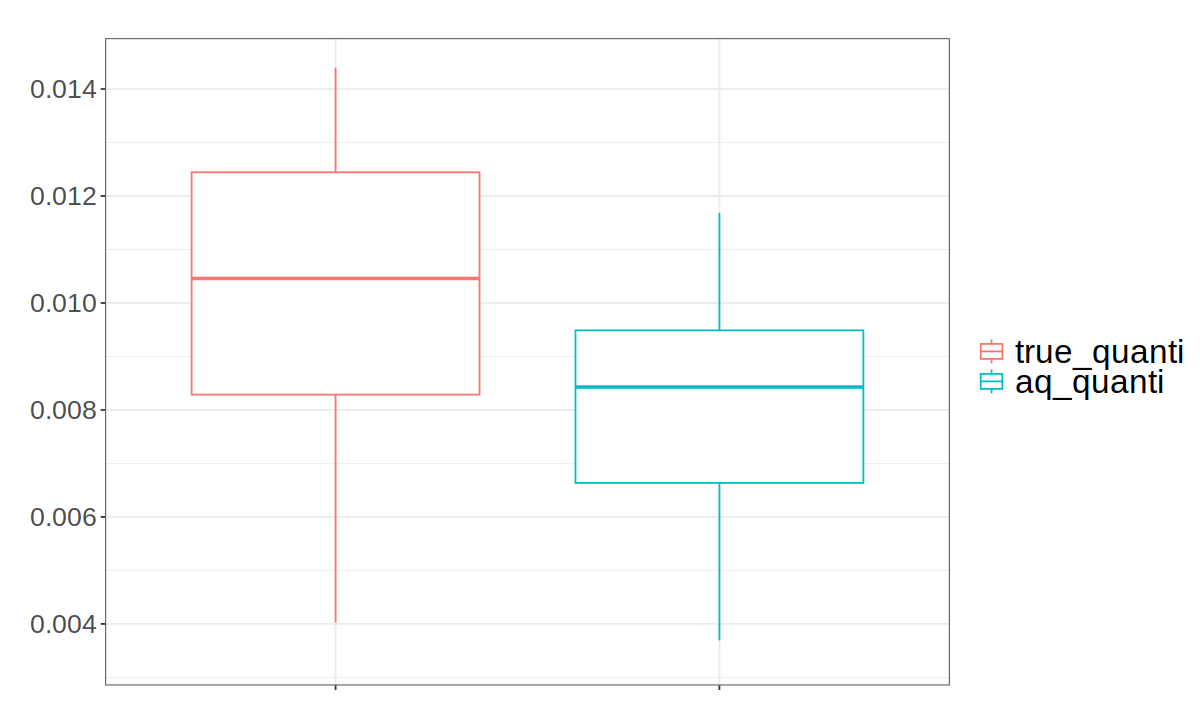

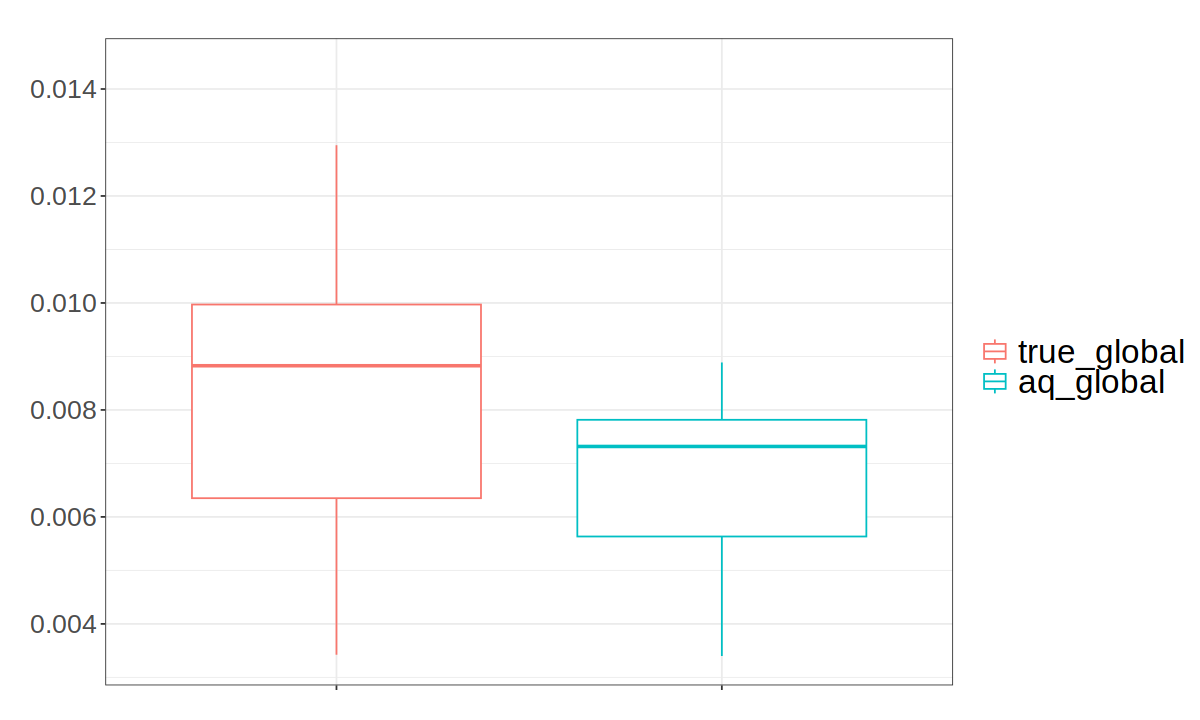

In [7]:
load("perf_hybrid.RData")

options(repr.plot.width = 10, repr.plot.height = 6)

true_quanti_errors = sapply(list_results$errors_true, function(x){x[[1]]}) #get true quantization errors
true_global_errors = sapply(list_results$errors_true, function(x){x[[2]]}) #true global errors

aq_quanti_errors = sapply(list_results$errors_aq, function(x){x[[1]]}) #AQ quantization errors
aq_global_errors = sapply(list_results$errors_aq, function(x){x[[2]]}) #AQ global errors

df <- data.frame( #gather all the results in a dataframe
  value = c(true_quanti_errors, true_global_errors, aq_quanti_errors, aq_global_errors),
  group = rep(c("true_quanti", "true_global", "aq_quanti", "aq_global"), each = length(true_quanti_errors))
)

df$group <- factor(df$group, levels = c("true_quanti", "true_global", "aq_quanti", "aq_global"))

y_limits <- range(df$value, na.rm = TRUE)
y_breaks <- pretty(y_limits, n = 6)  #same breaks for the two plots

p1 <- ggplot(df[df$group %in% c("true_quanti", "aq_quanti"),],  #plot quantization errors
             aes(x = group, y = value, col = group)) +
  geom_boxplot() +
  scale_color_manual(values = c("true_quanti" = "#F8766D", "aq_quanti" = "#00BFC4")) +
  scale_y_continuous(limits = y_limits, breaks = y_breaks) +
  labs(title = "", y = "", x = "") +
  theme_bw() +
  theme(axis.text.y = element_text(size = 16), axis.text.x = element_blank(),legend.title  = element_blank(), legend.text   = element_text(size = 20))

p2 <- ggplot(df[df$group %in% c("true_global", "aq_global"),], #plot global errors
             aes(x = group, y = value, col = group)) +
  geom_boxplot() +
  scale_color_manual(values = c("true_global" = "#F8766D", "aq_global" = "#00BFC4")) +
  scale_y_continuous(limits = y_limits, breaks = y_breaks) +
  labs(title = "", y = "", x = "") +
  theme_bw() +
  theme(axis.text.y = element_text(size = 16), axis.text.x = element_blank(),legend.title  = element_blank(), legend.text   = element_text(size = 20))

p1
p2


### Illustration of an obtained mixture and comparison with the true mixture

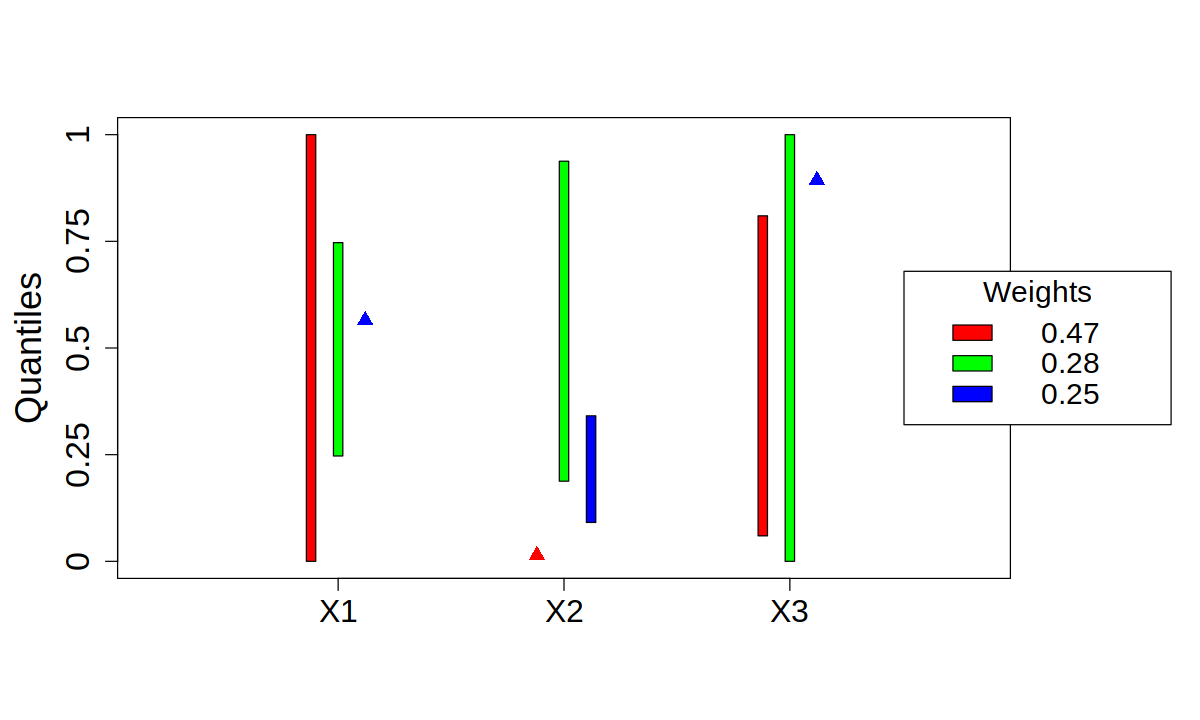

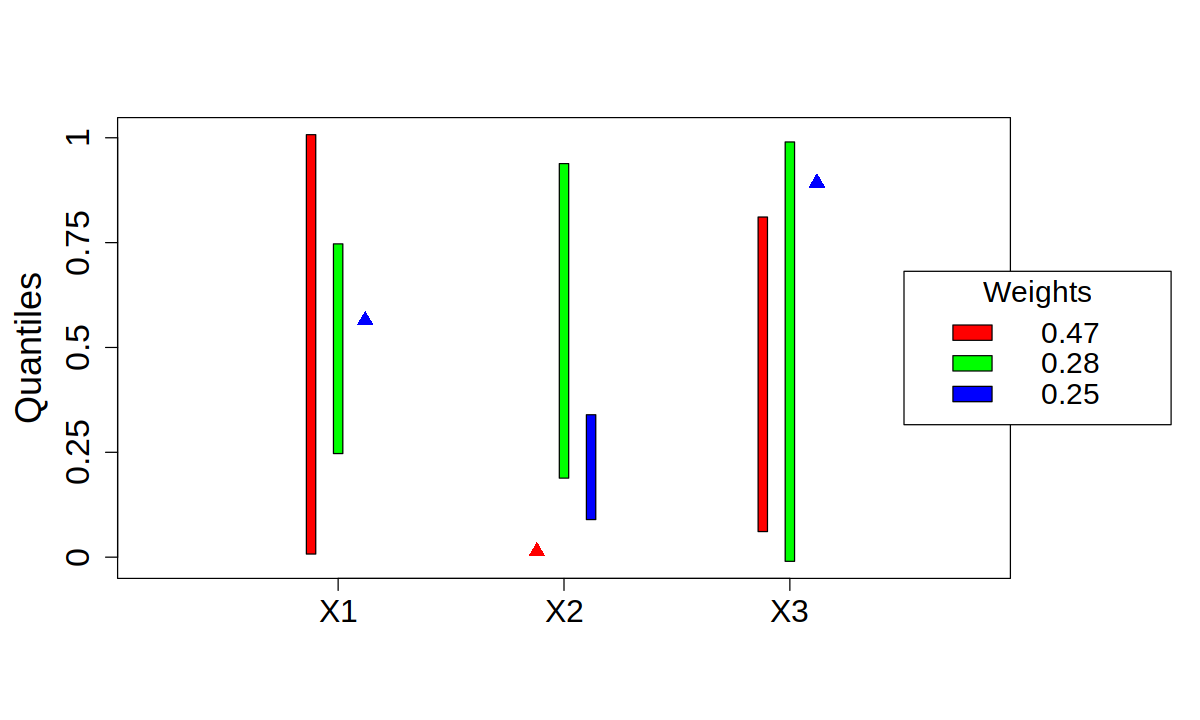

In [8]:

df_plot = create_df_plot(list_results$true_mixt[[3]][[2]], list_results$true_mixt[[3]][[1]])
plot_hybrid_distrib(df_plot,c("X1","X2","X3"), cex_legend = 1.5, ysize = 1.7)

df_plot = create_df_plot(list_results$aq_mixt[[3]][[2]], list_results$aq_mixt[[3]][[1]])
plot_hybrid_distrib(df_plot,c("X1","X2","X3"), cex_legend = 1.5, ysize = 1.7)